# Locality Sensitive Hashing for Search-by-Image Applications

## Imports

In [21]:
# === Imports === #
import os
import math
import numpy                  as np
import pandas                 as pd
import matplotlib.pyplot      as plt
from time                     import perf_counter
from PIL                      import Image
from sklearn.metrics.pairwise import cosine_similarity

## Setup

In [22]:
def update_runtimes( runtimes , label , val , type ):
    for i in range(len(runtimes)):
        if runtimes[i]['label'] == label:
            runtimes[i]['val'] = val
            return runtimes
    runtimes.append( { 'label':label , 'val':val , 'type':type } )
    return runtimes

runtimes = list( )  # list to hold runtimes
L = 20  # Number of hash strings to make
k = 20  # Lenght of each hash string
data_dir = 'dataset/intel_images/full'

## Construct Directory List

In [23]:
# ========================================================
# get_directory_list
# ========================================================
# Input: 
#   - data_dir: string containing absolute or relative path
#               to the root of the data files
# Output:
#   - list containing all subdirectories in the given data_dir
#     except for ".DS_Store" and "README"
# Task:
#   - Iterate over the directory list, and generate a new
#     list of the appropriate subdirectories
# ========================================================
def get_directory_list( data_dir ):
    return [ d for d in os.listdir( data_dir ) if d != '.DS_Store' and d != 'README' ]

# === Time the Directory List Extraction === #
t0 = perf_counter( )
dir_list = get_directory_list( data_dir )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Directory List Construction' , ( t1 - t0 ) , 0 )

# === Print Results === #
print( 'Directory List:\n' , dir_list )


Directory List:
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## Constructing File List

In [24]:
# ========================================================
# get_file_list
# ========================================================
# Input: 
#   - data_dir: string containing the path to the root directory
#               of the data files
#   - dir_list: list of data subdirectories to use
#   - sample_indices: list/array if ints denoting which pgm files
#                     to use
# Output:
#   - list containing strings. Each being the absolute/relative path
#     to the data files to be used
# Task:
#   - For each directory in the given dir_list, and for each
#     sample index in the given sample_indices, create a filepath
#     by concatenating "data_dir/directory/sample index.pgm"
# ========================================================
def get_file_list( data_dir , dir_list ):
    return [ data_dir + '/' + d + '/' + f 
             for d in dir_list 
             for f in os.listdir( data_dir + '/' + d ) ]


# === Time Construction of File List === #
t0 = perf_counter( )
file_list = get_file_list( data_dir , dir_list )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'File List Construction' , ( t1 - t0 ) , 0 )


# === Print Output === #
print( 'File List:\n' , file_list[:10] )

File List:
 ['dataset/intel_images/full/buildings/0.jpg', 'dataset/intel_images/full/buildings/10006.jpg', 'dataset/intel_images/full/buildings/1001.jpg', 'dataset/intel_images/full/buildings/10014.jpg', 'dataset/intel_images/full/buildings/10018.jpg', 'dataset/intel_images/full/buildings/10029.jpg', 'dataset/intel_images/full/buildings/10032.jpg', 'dataset/intel_images/full/buildings/10056.jpg', 'dataset/intel_images/full/buildings/1009.jpg', 'dataset/intel_images/full/buildings/10113.jpg']


## Get Dimensions of the Data

In [25]:
# ========================================================
# get_data_dimensions
# ========================================================
# Input: 
#   - file_list: list of all data filepaths
# Output:
#   - Tuple containing the shape of the image, as determined by
#     numpy.shape
# Task:
#   - Open the first image in the file list, and use numpy
#     to compute it's shape
# ========================================================
def get_data_dimensions( file_list ):
    return np.shape( Image.open( file_list[0] ).convert( "L" ) )


# === Call get_data_dimensions With Appropriate Values === #
t0 = perf_counter( )
H , W = get_data_dimensions( file_list )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Dimension Extraction' , ( t1 - t0 ) , 0 )

# === Print the Output === #
print( 'Shape = %d x %d => %d Pixels' % ( H , W , H*W ) )


Shape = 150 x 150 => 22500 Pixels


## Function to Display Image Grid (borrowed from HW4)

In [26]:
# ========================================================
# image_grid
# ========================================================
# Input: 
#   - D: array of image vectors
#   - H, W: dimensions of the image
#   - cols: number of images to show on each row
#   - scale: 1 --> fit the screen
# Output:
#   - display the given images in the specified way using
#     inline matplotlib pyplots
# Task:
#   - Iterate over each image in D, and use matplotlib.pyplot
#     to display it as specified
# ========================================================
def image_grid( D , H , W , cols=10 , scale=1 ):
    """ display a grid of images
        H,W: Height and width of the images
        cols: number of columns = number of images in each row
        scale: 1 to fill screen
    """
    n    = np.shape( D )[0]
    rows = int( math.ceil( ( n + 0.0 ) / cols ) )
    fig  = plt.figure( 1 , figsize=[ scale * 20.0/H * W , scale * 20.0/cols * rows ] , dpi=300 )
    for i in range( n ):
        plt.subplot( rows , cols , i + 1 )
        fig = plt.imshow( np.reshape( D[i,:] , [H,W,3] ).astype( int ) )
#        fig = plt.imshow( np.reshape( D[i,:] , [H,W] ) , cmap=plt.get_cmap( "gray" ) )
        plt.axis( 'off' )
    plt.show( )


## Reading in the Data

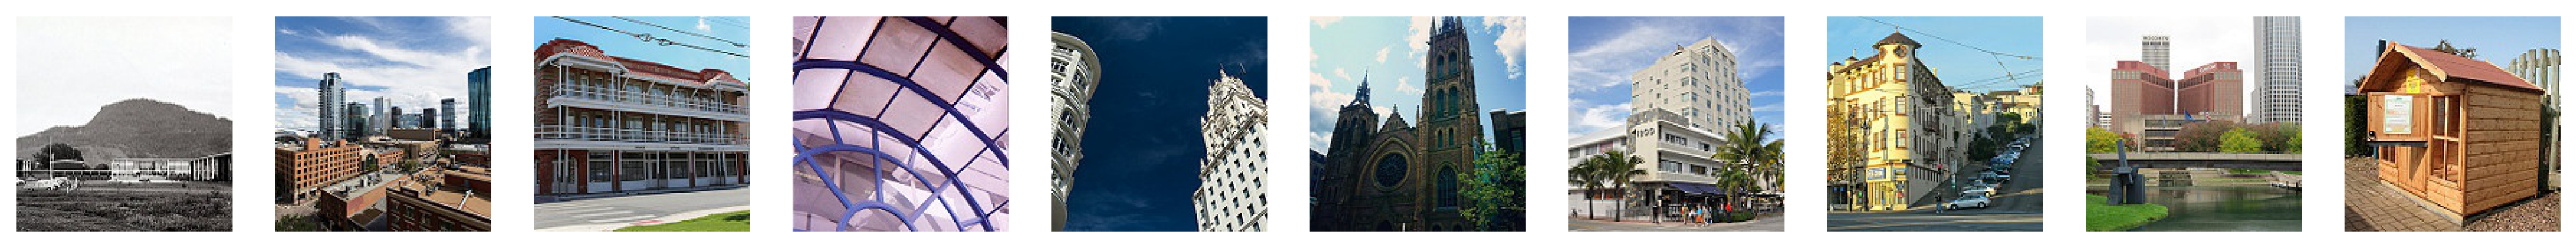

In [27]:
# ========================================================
# create_images_array
# ========================================================
# Input: 
#   - file_list: list of data filepaths to use
#   - H, W: dimensions of the image
# Output:
#   - numpy array containing the extracted image vectors for 
#     each specified image
# Task:
#   - Iterate over the given file list
#   - Open the image file
#   - Resize the image if necessary (if H,W doesn't match)
#     the image's dimensions
#   - Convert into a vecotr, and store as a row in the output
#     array
#   - return the final output array when done iterating
# ========================================================
#def create_images_array( file_list , H , W ):
#    im_number = len( file_list )
#    arr       = np.zeros( [ im_number , H * W ] )
#    for i in range( im_number ):
#        im = Image.open( file_list[i] ).convert( "L" )
#        if np.shape( im ) != ( H , W ):
#            im = im.resize( ( W , H ) )
#        arr[i,:] = np.reshape( np.asarray( im ) , [ 1 , H * W ] )
#    return arr
def create_images_array( file_list , H , W ):
    im_number = len( file_list )
    arr       = np.zeros( [ im_number , H * W * 3 ] )
    for i in range( im_number ):
        im = Image.open( file_list[i] ).convert("RGB")
        if np.shape( im ) != ( H , W ):
            im = im.resize( ( W , H ) )
        arr[i,:] = np.reshape( np.asarray( im ) , [ 1 , H * W * 3 ] )
    return arr


# === Call create_images_array On file_list === #
t0 = perf_counter( )
arr = create_images_array( file_list , H , W )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Data Read' , ( t1 - t0 ) , 0 )


# === Show Successful Load by Displaying First 10 in Image Grid === #
image_grid( arr[:10] , H , W )

# LSH

## Create the Hash Functions

In [28]:
def create_single_hash_function( dimensions , thresholds ):
    return lambda v: ''.join(['1' if v[dimensions[i]] > thresholds[i] else '0' for i in range(len(dimensions))])

def create_hash_function_list( L , k , max_dimension , min_threshold=0 , max_threshold=255 ):
    functions = list( )
    for i in range( L ):
        dimensions = np.random.randint( low=0             , high=max_dimension , size=k )
        thresholds = np.random.randint( low=min_threshold , high=max_threshold , size=k )
        functions.append( create_single_hash_function( dimensions , thresholds ) )
    return functions

# === Time the Construction of Hash Function List === #
t0 = perf_counter( )
hash_functions = create_hash_function_list( L , k , W*H )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Create Hash Functions' , ( t1 - t0 ) , 0 )

# === Output Number of Functions Created to Show Success === #
print( 'Number of Hash Functions: ' , len( hash_functions ) )


Number of Hash Functions:  20


## Hash the Dataset

In [29]:
def create_hashed_data_array( L , k , arr , hash_functions ):
    hashed_arr = np.empty((len(arr),L), dtype='S'+str(k))
    for i in range(len(hash_functions)):
        hashed_arr[:,i] = np.apply_along_axis( hash_functions[i] , 1 , arr )
    return hashed_arr

# === Time to Hash the Data === #
t0 = perf_counter( )
hashed_arr = create_hashed_data_array( L , k , arr , hash_functions )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Hash the Dataset' , ( t1 - t0 ) , 0 )

# === Print First 1 to Show Success === #
print(hashed_arr[:2])


[[b'11111111111111111111' b'11111111111111101111' b'11111111111111111111'
  b'11111101111111111101' b'11111111111111111111' b'11111111111111111111'
  b'10111111111111101111' b'11101111111111111111' b'11111111111111111111'
  b'11111111111111110111' b'11111111111111111111' b'11111111110111111111'
  b'11111111111111111111' b'11111111111111111111' b'11111110111111111111'
  b'11111101111111111111' b'11111111111111111111' b'11111111111111101111'
  b'11011111111011111111' b'11101111111111111111']
 [b'11111101001111100011' b'11111101110111101111' b'01110111110011101111'
  b'01101101101111001101' b'11111110010011011001' b'01101111111111011100'
  b'00011111110110101100' b'11001111111111110111' b'11010101011111101001'
  b'01111001000101100110' b'11111111110010111101' b'11111011110111000011'
  b'11111011101110110111' b'10111011110001111110' b'11001110101011011101'
  b'10011001101111111111' b'10111011110111001111' b'11111111101110101011'
  b'11001110101011111101' b'10101110111111110011']]


# Query

## Read the Query Image

Query Label: mountain
Query Image:


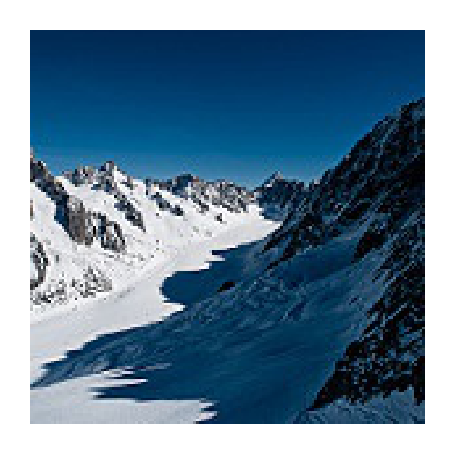

In [30]:
# === Read Into Array === #
t0 = perf_counter( )
query_image_file = 'query/patch-593.jpg'
query_label_file = 'query/patch-593.txt'
query_arr = create_images_array( [ query_image_file ] , H , W )
with open( query_label_file ) as qlf:
    query_label = qlf.read()
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Extract Query Data' , ( t1 - t0 ) , 1 )

# === Display to Show Success === #
print( 'Query Label: {}'.format( query_label ) )
print('Query Image:')
image_grid( query_arr , H , W )

## Hash the Query

In [31]:
# === Time to Hash the Data === #
t0 = perf_counter( )
query_hash = create_hashed_data_array( L , k , query_arr , hash_functions )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Hash the Query' , ( t1 - t0 ) , 1 )

# === Print First 1 to Show Success === #
print( 'Hashed Query: ' , query_hash )


Hashed Query:  [[b'00010001000001000000' b'00001100000001000000' b'00110000000001000001'
  b'00100000000000000100' b'00101000000000010000' b'01001001100000011000'
  b'00000000000010000000' b'00001010000110000001' b'01010101000100000000'
  b'01100000000101000110' b'01111001010000001100' b'00100000000010000000'
  b'01000000000000000001' b'00101000000000000000' b'00001000001000001100'
  b'00000000100000101001' b'00000010000000000101' b'10100011100000101010'
  b'10000100000010100101' b'00000000010010100011']]


## Find all Candidates (Hashed to the Same Value at Least Once)

In [32]:
def get_candidates( arr , hashed_arr , query_hash , file_list ):
    candidate_indices = np.any( hashed_arr==query_hash , axis=1 )
    candidates = arr[ candidate_indices ]
    candidate_files = [ file_list[i] for i in range( len( file_list ) ) if candidate_indices[i] ]
    return candidates , candidate_files

# === Filter the Candidate Images === #
t0 = perf_counter( )
candidates , candidate_files = get_candidates( arr , hashed_arr , query_hash , file_list )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Filter Candidates' , ( t1 - t0 ) , 1 )

# === Show Success by Printing Number of Candidates Found === #
print( 'Number of Candidates: ' , candidates.shape[0] )

Number of Candidates:  795


## Get N Nearest Neighbors

In [33]:
def get_n_neighbors( query_arr , candidates , num_neighbors ):
    similarities = np.zeros( ( len( candidates ) , 2 ) , dtype=object )
    similarities[:,0] = [ i for i in range( len( candidates ) ) ]
    similarities[:,1] = cosine_similarity( query_arr , candidates )
    neighbors = sorted( similarities , key=lambda x: x[1] , reverse=True )
    neighbors = neighbors[ : min(num_neighbors , len( neighbors ) ) ]
    neighbor_candidates = candidates[ [ n[0] for n in neighbors ] ]
    neighbor_files = [ candidate_files[ n[0] ] for n in neighbors ]
    return neighbors , neighbor_candidates , neighbor_files

t0 = perf_counter( )
num_neighbors = 10
neighbors , neighbor_candidates , neighbor_files = get_n_neighbors( query_arr , candidates , num_neighbors)
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Query for N Neighbors' , ( t1 - t0 ) , 1 )

print( '{} Nearest Neighbors'.format( num_neighbors ) )
print( neighbors )


10 Nearest Neighbors
[array([401, 0.8440224180600023], dtype=object), array([380, 0.8423846836998474], dtype=object), array([251, 0.8238565388069897], dtype=object), array([651, 0.8107684952913274], dtype=object), array([247, 0.810372138227697], dtype=object), array([347, 0.8063472413229117], dtype=object), array([230, 0.803206607016399], dtype=object), array([500, 0.8017737788637183], dtype=object), array([604, 0.8014794969042787], dtype=object), array([337, 0.8012610000258782], dtype=object)]


# Results

## Print Nearest Neighbor Files and Scores

In [34]:
def display_neighbors_metadata( neighbors , candidate_files ):
    rank = 1
    for neighbor in neighbors:
        print('{}:'.format(rank))
        print('\tFile: \"{}\"'.format(candidate_files[neighbor[0]]))
        print('\tCosine to Query: {}\n'.format(neighbor[1]))
        rank += 1
        continue
    return

print('Neighbors in Descending Order of Similarity:\n')
display_neighbors_metadata( neighbors , candidate_files )

Neighbors in Descending Order of Similarity:

1:
	File: "dataset/intel_images/full/glacier/6460.jpg"
	Cosine to Query: 0.8440224180600023

2:
	File: "dataset/intel_images/full/glacier/4159.jpg"
	Cosine to Query: 0.8423846836998474

3:
	File: "dataset/intel_images/full/glacier/10476.jpg"
	Cosine to Query: 0.8238565388069897

4:
	File: "dataset/intel_images/full/sea/22688.jpg"
	Cosine to Query: 0.8107684952913274

5:
	File: "dataset/intel_images/full/glacier/10130.jpg"
	Cosine to Query: 0.810372138227697

6:
	File: "dataset/intel_images/full/glacier/22347.jpg"
	Cosine to Query: 0.8063472413229117

7:
	File: "dataset/intel_images/full/forest/7899.jpg"
	Cosine to Query: 0.803206607016399

8:
	File: "dataset/intel_images/full/mountain/22124.jpg"
	Cosine to Query: 0.8017737788637183

9:
	File: "dataset/intel_images/full/sea/16700.jpg"
	Cosine to Query: 0.8014794969042787

10:
	File: "dataset/intel_images/full/glacier/21053.jpg"
	Cosine to Query: 0.8012610000258782



## Neighbors on Image Grid

Query:


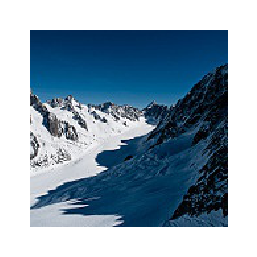

Ordered Neighbors:


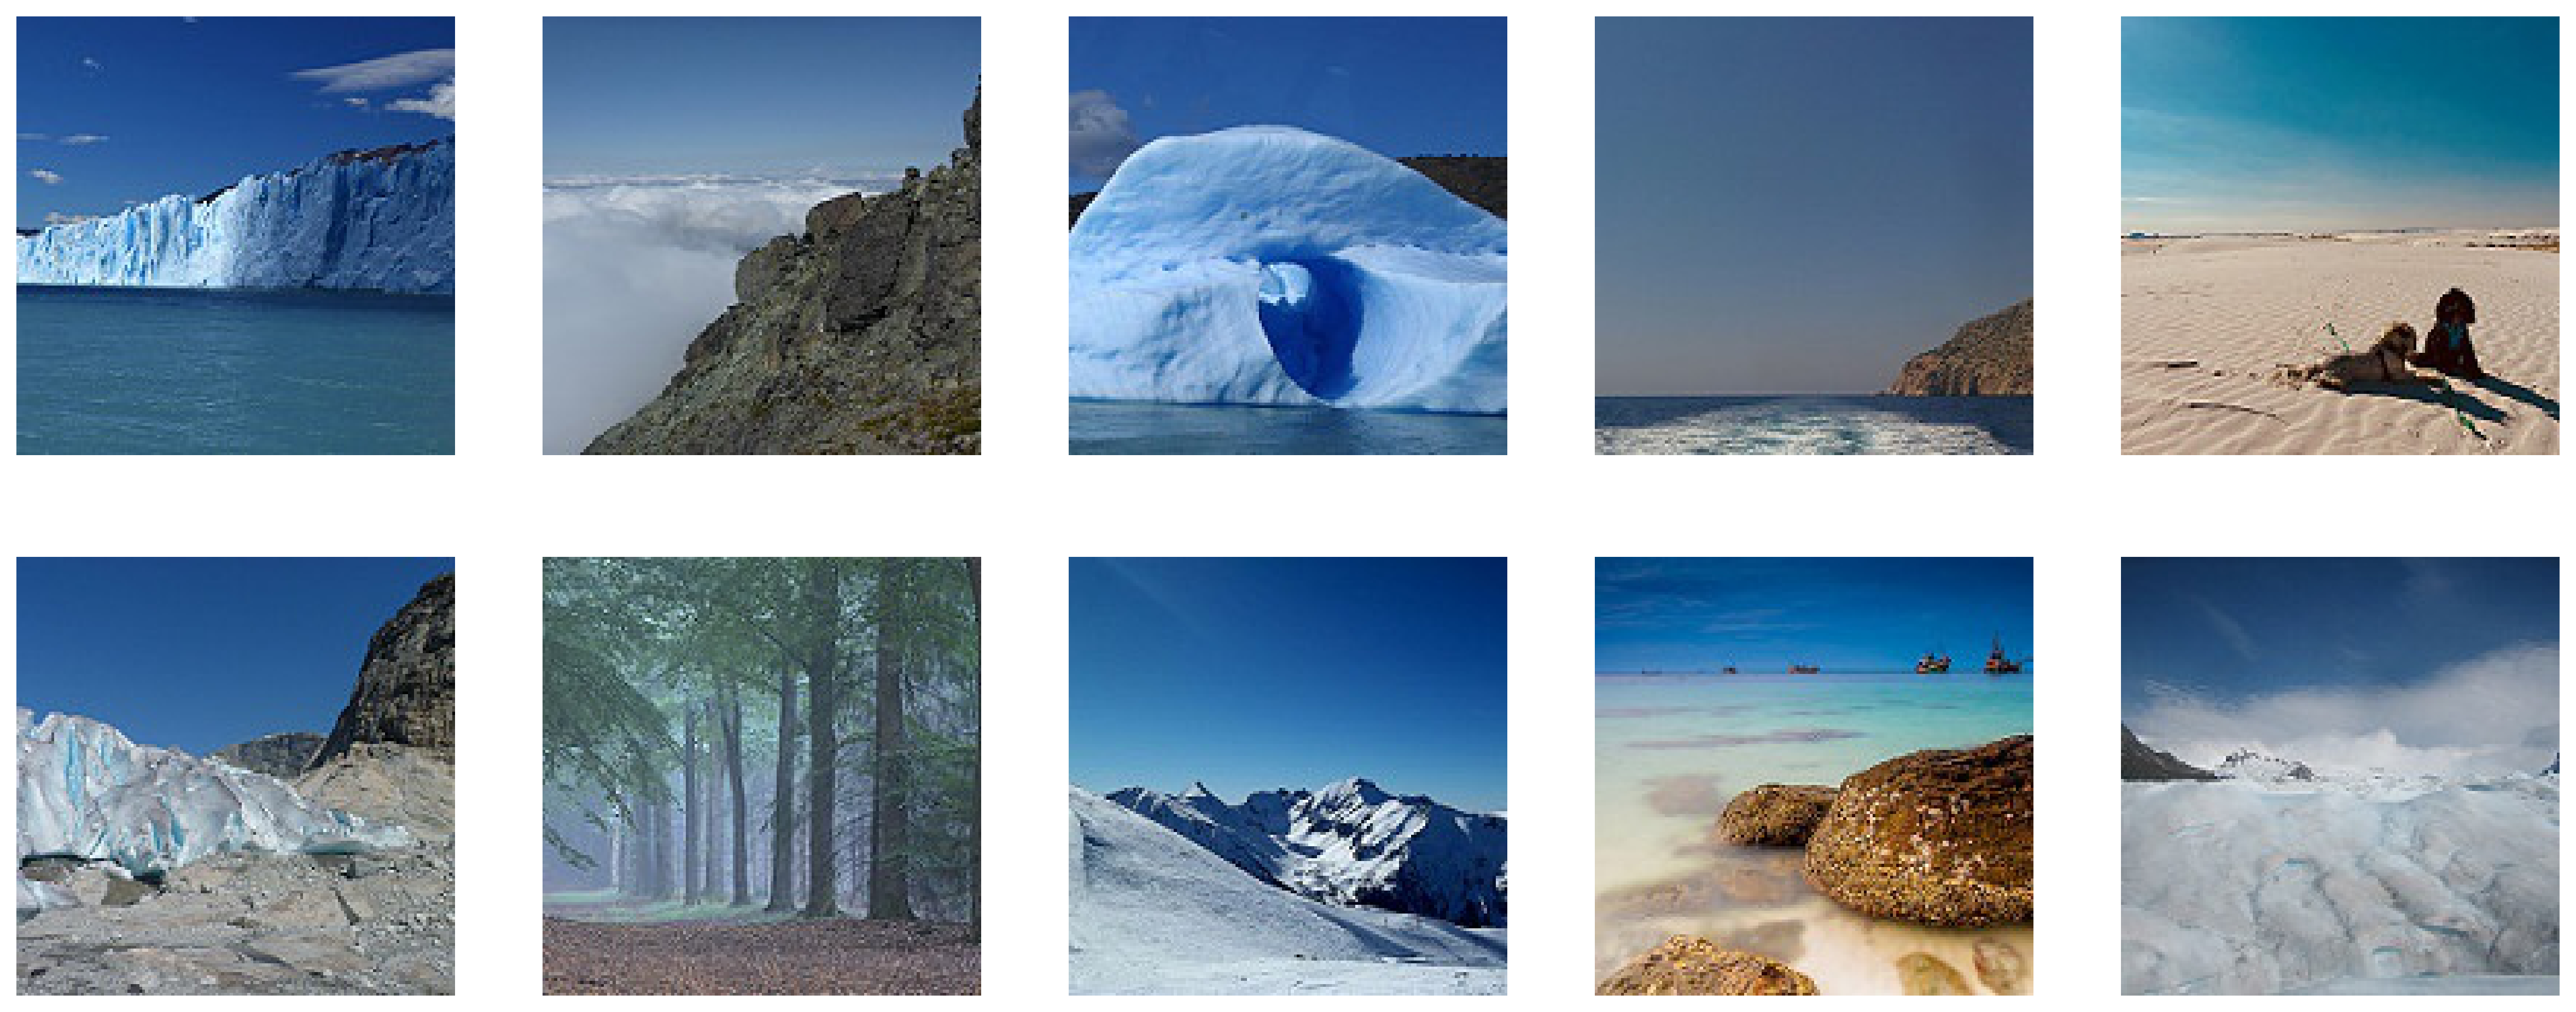

In [35]:
def display_query_results_images( query_arr , neighbor_candidates , H , W ):
    print('Query:')
    image_grid( query_arr , H , W , scale=0.5 )
    print('Ordered Neighbors:')
    image_grid( neighbor_candidates , H , W , cols=5 )
    return

display_query_results_images( query_arr , neighbor_candidates , H , W )

## N-Neighbors Output Distribution

In [36]:
def get_neighbor_classes( data_dir , neighbor_files ):
    neighbor_classes = dict()
    neighbor_classes['buildings'] = 0
    neighbor_classes['forest'] = 0
    neighbor_classes['glacier'] = 0
    neighbor_classes['mountain'] = 0
    neighbor_classes['sea'] = 0
    neighbor_classes['street'] = 0
    y = neighbor_files.copy()
    for i in range(len(y)):
        y[i] = y[i].replace(data_dir,'')[1:]
        y[i] = y[i][:y[i].index('/')]
        neighbor_classes[y[i]] += 1
        continue
    return neighbor_classes


neighbor_classes = get_neighbor_classes( data_dir , neighbor_files )
print('Class Occurrences:')
for nc in neighbor_classes.keys():
    print('\t{}: {}'.format(nc, neighbor_classes[nc]))\
    

Class Occurrences:
	buildings: 0
	forest: 1
	glacier: 6
	mountain: 1
	sea: 2
	street: 0


## Confusion Matrix

In [37]:
def get_data_totals( arr , candidates ):
    total_files = len( arr )
    total_truths = len( candidates )
    total_falses = total_files - total_truths
    return total_files , total_truths , total_falses
    
def get_confusion_matrix( data_dir , file_list , candidate_files , query_label ):
    TP , TN , FP , FN = 0 , 0 , 0 , 0
    for file in file_list:
        label = file
        label = label.replace(data_dir,'')[1:]
        label = label[:label.index('/')]
        if file in candidate_files:
            if label == query_label:
                TP += 1
            else:
                FP += 1
        else:
            if label == query_label:
                FN += 1
            else:
                TN += 1
    return TP , TN , FP , FN
    
    
total_files , total_truths , total_falses = get_data_totals( arr , candidates )
print( 'Total Files: ' , total_files )
print( 'Total Truths: ' , total_truths )
print( 'Total Falses: ' , total_falses )
print('')


TP , TN , FP , FN = get_confusion_matrix( data_dir , file_list , candidate_files , query_label )
print('True Positives: {}'.format(TP))
print('False Positives: {}'.format(FP))
print('True Negatives: {}'.format(TN))
print('False Negatives: {}'.format(FN))

Total Files:  17034
Total Truths:  795
Total Falses:  16239

True Positives: 125
False Positives: 670
True Negatives: 13327
False Negatives: 2912


## Time Cost

In [38]:
def display_time_costs( runtimes ):
    total_time = 0
    preprocess_time = 0
    query_time = 0

    for runtime in runtimes:
        print('{}: {}s'.format(runtime['label'], runtime['val']))
        total_time += runtime['val']
        if runtime['type'] == 0:
            preprocess_time += runtime['val']
        elif runtime['type'] == 1:
            query_time += runtime['val']

    print('')
    print('Preprocessing Time (Only Needed Once): {}s'.format(preprocess_time))
    print('Query Time: {}s'.format(query_time))
    print('Total Time: {}s'.format(total_time))
    return


display_time_costs( runtimes )

Directory List Construction: 0.0012764000020979438s
File List Construction: 0.03216990000146325s
Dimension Extraction: 0.02812439999979688s
Data Read: 23.59645239999736s
Create Hash Functions: 0.015054300001793308s
Hash the Dataset: 31.26092029999927s
Extract Query Data: 0.015471800001250813s
Hash the Query: 0.0018052000013994984s
Filter Candidates: 0.9201840000023367s
Query for N Neighbors: 0.45736810000016703s

Preprocessing Time (Only Needed Once): 54.93399770000178s
Query Time: 1.394829100005154s
Total Time: 56.32882680000694s


## Confustion Matrix Evaluation Metrics

In [39]:
def calculate_performance_metrics( TP , TN , FP , FN ):
    metrics = dict()
    metrics['accuracy'] = ( TP + TN ) / ( TP + FP + TN + FN )
    metrics['precision'] = TP / ( TP + FP )
    metrics['recall'] = TP / ( TP + FN )
    metrics['F1'] = ( 2 * metrics['precision'] * metrics['recall'] ) / ( metrics['precision'] + metrics['recall'] )
    metrics['MCC'] = ( TP * TN - FP * FN ) / ( np.sqrt( ( TP + FP ) * ( TP + FN ) * ( TN + FP ) * ( TN + FN ) ) )
    metrics['FDR'] = FP / ( FP + TP )
    metrics['TPR'] = TP / ( TP + FP + TN + FN )
    metrics['FPR'] = FP / ( TP + FP + TN + FN )
    metrics['TNR'] = TN / ( TP + FP + TN + FN )
    metrics['FNR'] = FN / ( TP + FP + TN + FN )
    return metrics
            
metrics = calculate_performance_metrics( TP , TN , FP , FN )
print('METRICS FOR DEMO QUERY:\n')
print('Accuracy: {}'.format(metrics['accuracy']))
print('Precision: {}'.format(metrics['precision']))
print('Recall: {}'.format(metrics['recall']))
print('F1: {}'.format(metrics['F1']))
print('MCC: {}'.format(metrics['MCC']))
print('FDR: {}'.format(metrics['FDR']))
print('')
print('True Positive Rate: {}'.format(metrics['TPR']))
print('False Positive Rate: {}'.format(metrics['FPR']))
print('True Negative Rate: {}'.format(metrics['TNR']))
print('False Negative Rate: {}'.format(metrics['FNR']))

METRICS FOR DEMO QUERY:

Accuracy: 0.7897146882705178
Precision: 0.15723270440251572
Recall: 0.04115903852486006
F1: 0.0652400835073069
MCC: -0.012172874327882274
FDR: 0.8427672955974843

True Positive Rate: 0.007338264647176236
False Positive Rate: 0.03933309850886462
True Negative Rate: 0.7823764236233416
False Negative Rate: 0.1709522132206176


In [20]:
# TODO
#  1. average runtime for ~10 queries for each class
#  2. average metrics for the queries in 1
# NOTE:
#  - we don't need to display the query results, we're just getting query performance
#    measures to average

# Objective Evaluation

Due to the randomness of the generated thresholds, the performance depended heavily on the values of L and k (number of hash functions, and the length of the hash strings). LSH attempts to greatly reduce the number of candidates by hashing the data into L different hash strings of length k. Due to the fact that querying is dependent on hashing, LSH favors rejecting data over accepting. This increases the True Negative and False Negative rates, but also reduces the True Positive and False Positive rates. When tested with L=20 and k=10, the performance was poor. Accuracy values as low as `0.07` and as high as `0.17` -- This is because the hashing was not effectively filtering the candidates (~33.33% of the dataset was candidates). When testing with L=20 and k=20, the hashing was significantly more effective at filtering the data (reducing to 90-300 candidates out of the ~17000 images). With these values, accuracy improved to approximately `0.79` to `0.82`. The majority of this accuracy improvement is due to the increase in True Negatives. 

This method is not the most effective at classifying an image, but is "decent" at correctly excluding members of different classes. Another point to consider is the similarity metric. This program uses cosine similarity on the grayscale images. This means that color filtering is not present, and the similarity rankings are solely evaluated on the brightness/light-dark values. This can result in images with similar shading to hash to the same bucked and be flagged as candidates

# Subjective Evaluation

LSC did not do a good job at showing images of the same class. Often, none of the n nearest neighbors would be the same class as the query. However, all of the images shown as "nearest neighbors" were visually similar to the query. The neighbors would have similar light-dark patterns to the query. For example, when the query image `patch-593.jpg` (mountain with light lower-left and dark rest) was used, the most similar neighbors all had a light lower left and a dark rest. It would be interesting to see how performance would change with greater parameter tuning, as well as using colors -- either in the candidate search or in the candidate similarity

# Ideas for Future Improvements

1. Enable the ability to save the hashed data, so that it only needs to be one if the hash file doesn't exist, if L/k changes, or if manually told to update the hash.
2. Enable the use of the RGB color channels, rather than grayscale, to evalueate how color affects the performance of LSH, both in terms of time-cost, memory-cost, and confusion matrix metrics
3. The full dataset is currently held in memory, but is only used when hashing, and when extracting the candidates from it. It would be interesting to optimize memory usage by directly hashing the data files without extracting the 17k 150x150 images into memory, and only load the candidate files after hashes have determined the candidates. I am unsure whether this will affect query time cost, but it should reduce the memory cost from nx150x150 data values to num_candidatesx150x150. When L=20 and k=20, this is a 98-99.5% reduction in memory cost. Making the memory cost as lightweight as possible, should help improve overall performance.Also, since reading the full dataset into memory is the largest time bottleneck (approximately 16s), removing that cost should improve overall runtime, even if candidates must be read during the query.
4. Since each image file is mutually exclusive, images can be hashed in parallel, reducing the hashing time cost.
5. I would be interested in seeing if LSH can be performed on PCA to either further reduce number of comparisons per-query, or reduce the memory cost of the overall dataset.